<center><img src="http://what-when-how.com/wp-content/uploads/2012/07/tmp26dc139_thumb.png" width=50% > </center>

# <center> Assignment 2: Neighborhood Processing & Filters </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59PM, September 24, 2022 (Amsterdam time) </center>
    
***

## (100 pts)

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 2 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure you follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.signal import convolve2d as conv
import requests

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert sklearn.__version__ == "0.23.0"

# Proceed to the next cell only if you don't get any error.


# 1 Introduction 


In this assignment, you will get familiar with fundamentals of neighborhood processing for image processing. These techniques allow for low-level image understanding via extraction of structural patterns such as edges and blobs. Similarly, they find an extensive use in image denoising and higher level image reasoning such as shape recognition. Moreover, neighborhood or block processing is one of the key components of *Convolutional Neural Networks*. Therefore, a good understanding of these
procedures will be a stepping stone towards understanding more complex machinery used in computer vision and machine learning.

In subsequent sections of this assignment, we will first explain neighborhood processing and introduce low-level filters commonly used to analyze images. After that, we will see how these mathematical concepts relate to practice by working through fundamental tasks such as denoising and segmentation. By the end of this assignment, you will have an overall understanding of the following:
* Gaussian and Gabor filters
* Edge detection and image denoising
* Texture-based image segmentation


---


First we need two helper functions 

In [3]:
### Use this for the last exercise

def load_image(image_id: str='Polar'):
  '''
  Loads an image, resizes image with proper resize factor and sets proper color representation
  :param image_id: id of an image: Kobi, Polar, Robin-1, Robin-2, Cows, SciencePark
  :return: image
  '''
  if image_id == 'Kobi':
    img = cv2.imread('./sample_data/kobi.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.25
  elif image_id == 'Polar':
    img = cv2.imread('./sample_data/polar-bear-hiding.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.75
  elif image_id == 'Robin-1':
    img = cv2.imread('./sample_data/robin-1.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 1
  elif image_id == 'Robin-2':
    img = cv2.imread('./sample_data/robin-2.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.5
  elif image_id == 'Cows':
    img = cv2.imread('./sample_data/cows.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.5
  elif image_id == 'SciencePark':
    img = cv2.imread('./sample_data/sciencepark.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.2
  else:
    raise ValueError('Image not available.')
  img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img

In [4]:
def show_image(image, image_title:str= "Polar", cmap='gray'):
  '''Displays image in grey scale'''
  plt.figure()
  plt.title(image_title)
  plt.imshow(image, cmap=cmap)
  plt.axis("off")

# 2 Neighborhood Processing


Neighborhood processing is simply about looking around a point $I(x, y)$ (i.e. pixel) in the image, $I$, and applying a function, $h(k, l)$, which measures certain properties or relationships between the pixels in that localized window. The function, $h(k, l)$, is generally referred to as the neighborhood operator or local operator. One of the most common forms of a neighborhood operator is a linear filter. Linear filters simply compute the weighted sum of neighboring pixel intensities and assign it to the pixel of interest (output $I_{out}(i, j)$). The filters in which we are interested here are usually represented as a square matrix.

---
**Hint**: Filters, kernels, weight matrices or masks are interchangeably used in the literature. A kernel is a matrix with which we describe a neighborhood operation. This operation can, for example, be edge detection or smoothing.

---

Linear filters are shifted over the entire image plane via operators such as correlation ($\otimes$) and convolution ($\ast$). Both of these operators are *linear shift-invariant* (LSI) implying that the filters behave the same way over the entire image. Discrete forms of these operators are given in the following:


Correlation (1):
<center>
$\mathbf{I}_{out} = I \otimes  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l}  \mathbf{I}(i+k,j+l) \mathbf{h}(k,l)$
</center>
Convolution (2):
<center>
$    \mathbf{I}_{out} = \mathbf{I} \ast  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l} \mathbf{I}(i-k,j-l) \mathbf{h}(k,l)$
 </center>


---
The following example illustrates the overall idea of neighborhood processing. The kernel or the mask convolves over the input image. In the case of linear filters, this is simply multiplying each pixel intensity with the corresponding weight in the kernel (see the yellowish $7x7$ window where the kernel is placed). In the example, the kernel is $7x7$ averaging mask. You can see its effect by comparing the red (before filtering) and the green (after filtering) frames.





**Example:**
![](https://drive.google.com/uc?export=view&id=1HXt-WTi2Mg-jHYU4tvcKl4R29gi-g1QY)

### Question (10 pts)
1.   What is the difference between correlation and convolution operators? How do they treat the signals $\mathbf{I}$ and $\mathbf{h}$?
2.   Correlation and convolution operators are equivalent when we make an assumption on the form of the mask $\mathbf{h}$. Can you identify the case?


**1.** The kernel of the convolution operator is flipped with respect to the kernel of the cross-correlation operator, both vertically and horizontally. That is, the convolution operator flips the kernel $\mathbf{h}$ before running it over the image $\mathbf{I}$. This can be seen as follows. Define a flip operator $F : \mathbb{R}^{N \times N} \rightarrow \mathbb{R}^{N \times N}$ such that $F(\mathbf{h}(k,l)) = \mathbf{h}( - k, - l)$ for $\mathbf{h} \in \mathbb{R}^{N \times N}$ (Note: $\mathbf{h}(0,0)$ corresponds to the center of the kernel so that $k,l \in [-\lfloor N/2\rfloor, \lfloor N/2\rfloor]$ and $N = 2n + 1$ with $n \in \{0, 1, 2, ...\}$)\
\
$$ \left[\mathbf{I} \otimes F(\mathbf{h})\right](i, j) = \sum_{k, l}I(i + k, j + l)h(-k, -l) 
= \sum_{m,n}I(i - m , j - n)h(m, n) = [\mathbf{I} * \mathbf{h}](i, j) $$\
\
where we defined $m = -k$ and $n = - l$.\
\
**2.** The correlation and convolution operators are equivalent if the kernel $\mathbf{h}$ is symmetric in its rows and columns. That is, it is invariant under the flip operator:

$$F(\mathbf{h}(k,l)) = \mathbf{h}(-k, -l) = \mathbf{h}(k, l)$$

# 3 Low-level filters


In this section, you will design common linear filters used in neighborhood processing. We will focus in particular on Gaussian and Gabor filters.

## 3.1 Gaussian Filters

### 3.1.1 1D Gaussian Filter



The 1D  Gaussian filter is defined as follows:
<center>
$ G_{\sigma}(x)=\frac{1}{\sigma\sqrt{2\pi}}\text{ exp}(-\frac{x^2}{2\sigma^2}),$
</center>
where $\sigma$ is the variance of the Gaussian. However, such formulation creates an infinitely large convolution kernel. In practice, the kernel is truncated with a `kernel_size` parameter such that $-\left\lfloor \frac{kernel\_size}{2}\right\rfloor \leq x \leq \left\lfloor \frac{kernel\_size}{2} \right\rfloor$, where $\left\lfloor . \right\rfloor$ is the floor operator. As an example, if `kernel_size` equals 3, $x \in \{ -1, 0, 1 \} $.

### Exercise 
Now, implement the following *gauss1D* function.

**Hint:** 
Do not forget to normalize your filter.

**Note:** You are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [5]:
def gauss1D(sigma, kernel_size):
    G = np.zeros((1, kernel_size))
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')
    
    x = np.arange(-(kernel_size//2), kernel_size//2 + 1)
    G = 1./(sigma*np.sqrt(2*np.pi))*np.exp(-x**2/(2*sigma**2))
    G = G/np.sum(G)
    

    return G   

In [6]:
# Run this to test your function:
assert np.all(np.round(gauss1D(2,5), 4) == [0.1525, 0.2218, 0.2514, 0.2218, 0.1525]) # check if values are close enough if assert gives error

### 3.1.2 2D Gaussian Filter



One of the most important properties of 2D Gaussian kernels is separability. Therefore, convolving an image with a 2D Gaussian is equivalent to convolving
the image twice with a 1D Gaussian filter, once along the x-axis and once along the y-axis **separately**. A 2D Gaussian kernel can then be defined as a product of two 1D Gaussian kernels:
<center>
$
G_{\sigma}(x, y) = G_{\sigma}(x) \times G_{\sigma}(y)$ *(Eq. A)*

$
 = \frac{1}{\sigma^2 2\pi}\text{ exp}(-\frac{x^2 + y^2}{2\sigma^2})
 $ *(Eq. B)*
 </center>

### Exercise 

Implement `gauss2D` function that corresponds to *Eq. A* (not *Eq. B*) and you should make use of `gauss1D`.

**Note:** Again, you are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [7]:
def gauss2D(sigma_x, sigma_y, kernel_size):
    Gx = gauss1D(sigma_x, kernel_size).reshape(kernel_size, 1)
    Gy = gauss1D(sigma_y, kernel_size).reshape(kernel_size, 1)
    G = Gx@Gy.T
    return G

In [8]:
# Run this to test your function:
assert np.all( np.round(gauss2D(2, 2, 3) , 4) == [[0.1019, 0.1154, 0.1019],
       [0.1154, 0.1308, 0.1154],
       [0.1019, 0.1154, 0.1019]])

### Question (5pts)
What is the difference between convolving an image with (1) a 2D Gaussian kernel and (2) a 1D Gaussian kernel in the x- and y-direction? Will the result be the same? What is their computational complexity?

**A:** Mathematically speaking, there is no difference between (1) and (2). This is because the 2D Gaussian kernel is seperable into two 1D Gaussians, one along each axis. This follows from the fact that $G_{\sigma}(x,y) = G_{\sigma}(x)\times G_{\sigma}(y)^T = G_{\sigma}(x) * G_{\sigma}(y)^T$, with $\times$ denoting matrix multiplication and $G_{\sigma}(x), G_{\sigma}(y) \in \mathbb{R}^m$ . Then using the distributive property of the convolution we have:\
\
$$ G_{\sigma}(x,y)*I = (G_{\sigma}(x)\times G_{\sigma}(y)^T)*I = (G_{\sigma}(x) * G_{\sigma}(y)^T)*I = G_{\sigma}(x) * (G_{\sigma}(y)^T*I) $$\
\
Computationally speaking, there is an important difference. Let $I$ be an image of $N \times N$ pixels and $G_{\sigma}(x), G_{\sigma}(y)$ kernels of size $m\times 1$, such that $G_{\sigma}(x,y)$ is a kernel of size $m \times m$. Then using method (1), for every pixel in the image, we need to perform $m^2$ multiplications to compute the convolution, for a total complexity of $\mathcal{O}(N^2m^2)$. On the other hand, using method (2) we need to perform two convolutions, but for each we need to do only $m$ multiplications per pixel, resulting in a total complexity of $\mathcal{O}(N^2m)$. Evidently, the second approach is faster in general.

### 3.1.3 Gaussian Derivatives
So far the Gaussian kernels that we computed are mainly targeted to image enhancement algorithms (e.g. denoising an image). These kernels can also be used for detecting changes in the image intensity pixels. These low-level features can then further be used as building blocks for more complicated tasks like object detection or segmentation.


Concretely, the  first order derivative of the 1D Gaussian kernel is given by:

<center>
$
\frac{d}{dx}G_\sigma(x)  =\frac{d}{dx}\left( \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2}) \right )$

$
 = -\frac{x}{\sigma^3\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2})$ 
*(Eq. C)*

 $
 = -\frac{x}{\sigma^2}G_\sigma(x)
 $
</center>
Similarly, the first order derivative of the 2D Gaussian kernel can be obtained by computing $\frac{d}{dx}G_\sigma(x,y)$ and $\frac{d}{dy}G_\sigma(x,y)$.

#### Question (5pts)
A second order derivative of the Gaussian kernel can also be computed. Why
is it interesting to design a second order kernel?

In the context of edge detection, pixels in an image that correspond to edges are generally the pixels where the intensity changes rapidly (in the direction perpendicular to the edge). As a result they appear as local maxima in the first order derivative of the (smoothened) image. By extension, these points correspond to the zeros of the second derivative of the (smoothened) image. In general the peaks in the first derivative can be quite wide, making it harder to actually localize the edge (since it appears more blurry). On the contrary, the zero-crossings in the second order derivative are much sharper and easier to localize making it easier to define the edges.

## 3.2 Gabor filters


Gabor filters fall into the category of linear filters and are widely used for *texture analysis*. The reason why they are a good choice for texture analysis is that they localize well in the frequency spectrum (*optimally* bandlimited) and therefore work as flexible *band-pass* filters.

In the following image you can see even (cosine-modulated) and odd parts (sine-modulated) of Gabor filters with fixed-σ Gaussian. You can observe time-domain filters for the modulating sinusoidals of central frequencies, 10, 20, 30, 40 and 50 Hz, respectively.


![](https://drive.google.com/uc?export=view&id=1wv6ZUOfiHMDgg0jW7n5lqkaFiFztjnEo)

Gabor filters with varying center frequencies are sensitive to different
frequency bands. Notice that the neighboring (in the frequency spectrum) filters minimally interfere with each other.

![](https://drive.google.com/uc?export=view&id=1hUQaKE_TwC-9_jMIao1CCxyjembMrUab)

### 3.2.1 1D Gabor Filters

For the sake of simplicity, we start by studying what a Gabor function is using 1D signals (e.g. speech). The idea will later be generalized to the 2D case, which is suited for our primary interest, images. A Gabor function is a Gaussian function modulated with a complex sinusoidal carrier signal. Let us denote the Gaussian with $x(t)$ and complex sinusoidal with $m(t)$. Then, a Gabor function $g(t)$ can be formulated by:

$
g(t) = x(t) m(t)   
$ *(Eq. D)*

where $x(t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}}$ and $m(t)=e^{j 2 \pi f_c t} = e^{j w_c t}$. $\sigma$ is the parameter determining the spread of the Gaussian and $w_c$ is the central frequency of the carrier signal.


---


**Hint:**
A complex sinusoidal can be represented as follows using the *Euler's formula*:
$e^{jwt} = \cos(wt) + j\sin(wt)$


---



Using Euler's formula, we get the following:
\begin{align}
    g(t) &= x(t)m(t) \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} e^{j w_c t} \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} [\cos(w_c t) + j\sin(w_c t)]
\end{align}
We can further arrange the terms and arrive at the following form
\begin{align}
    g(t) = g_e(t) + jg_o(t)
\end{align}
where $g_e(t)$ and $g_o(t)$ are the even and odd parts arranged orthogonally on the complex plane $\mathbf{Z}^2$. In practice, one can use either the even or the odd part for filtering purposes (or one can use the complex form).  

### 3.2.2 2D Gabor Filters


The Gabor filters can also be defined in 2D as well. The main difference lies in the dimensionality of the signals (i.e. carrier and gaussian). A sine wave in 2D is described by two orthogonal spatial frequencies $u_0$ and $v_0$ such that it is given as $s(x,y) = sin(2\pi(u_0 x + v_0 y))$ where a 2D gaussian is simply $C e^{-(\frac{(x-x_0)^2}{2\sigma_x^2}) + \frac{(y-y_0)^2}{2\sigma_y^2})}$ with $C$ being a normalizing constant. 2D Gabor function then takes the following forms in the real and complex parts:

\begin{align}
    g_{real}(x,y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\cos\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)                                              
\end{align}
\begin{align}
g_{im}(x,y; \lambda, \theta, \psi, \sigma, \gamma) &= \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\sin\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)
\end{align}

where
\begin{align}
    x^\prime &= x\cos\theta + y\sin\theta \\
    y^\prime &= -x\sin\theta + y\cos\theta
\end{align}

#### Question 4 (5pts)
Conduct a self-study on the Gabor filters. Explain shortly what the parameters $\lambda, \theta, \psi, \sigma, \gamma$ control.

λ: the wavelength of the sinusoidal carrier signal

θ: the orientation of the normal to parallel stripes of the Gabor function

ψ: phase offset of the sinusoidal carrier signal

σ: the standard deviation of the Gaussian function

γ: the spatial aspect ratio, that is the ellipticity of the Gaussian function

### Exercise 

##### Design array of Gabor Filters

Now, you will create a Gabor Filterbank. A filterbank is a collection of filters with varying properties (e.g. {shape, texture}). A Gabor filterbank consists of Gabor filters of distinct orientations and scales. We will use this bank to extract texture information from the input image. 

Your task is to implement function `createGabor` but to do that you will need some helper functions, which are defined below. Finish the implementation of those and then use them in `createGabor`.

In [9]:
def generateRotationMatrix(theta):
    # Returns the rotation matrix. 
    # Hint: https://en.wikipedia.org/wiki/Rotation_matrix
    
    rotMat = np.array( [ [np.cos(theta), - np.sin(theta) ], [ - np.sin(theta), np.cos(theta) ] ] )
    return rotMat


In [10]:
def createCos(rot_x, lamda, psi):
    # Returns the 2D cosine carrier. 
    
    cosCarrier = np.cos(2*np.pi*rot_x/lamda + psi)

    # Reshape the vector representation to matrix.
    cosCarrier = np.reshape(cosCarrier, (np.int32(np.sqrt(len(cosCarrier))), -1))
    return cosCarrier

In [11]:
def createSin(rot_x, lamda, psi):
    # Returns the 2D sine carrier. 
    sinCarrier = np.sin(2*np.pi*rot_x/lamda + psi)

    # Reshape the vector representation to matrix.
    sinCarrier = np.reshape(sinCarrier, (np.int32(np.sqrt(len(sinCarrier))), -1))
    return sinCarrier

In [12]:
def createGauss(rot_x, rot_y, gamma, sigma):
    # Returns the 2D Gaussian Envelope. 

    gaussEnv = np.exp(-(rot_x**2+gamma*rot_y**2)/2*sigma**2)
    # Reshape the vector representation to matrix.
    gaussEnv = np.reshape(gaussEnv, (np.int32(np.sqrt(len(gaussEnv))), -1))

    return gaussEnv

Implement the function `createGabor` using above helper functions and equations for $g_{real} $ and $g_{im}$. 


In [13]:
def createGabor(sigma, theta, lamda, psi, gamma, visualize=False):
    '''
    Creates a complex valued Gabor filter.
    myGabor = createGabor(sigma, theta, lamda, psi, gamma) generates Gabor kernels. 
    :param sigma: Standard deviation of Gaussian envelope.
    :param theta: Orientation of the Gaussian envelope. Takes arguments in the range [0, pi/2).
    :param lamda: The wavelength for the carriers. The central frequency (w_c) of the carrier signals.
    :param psi: Phase offset for the carrier signal, sin(w_c . t + psi).
    :param gamma: Controls the aspect ratio of the Gaussian envelope
    :return: myGabor - A matrix of size [h,w,2], holding the real and imaginary 
                        parts of the Gabor in myGabor(:,:,1) and myGabor(:,:,2), respectively.
    '''

    # Set the aspect ratio.
    sigma_x = sigma
    sigma_y = float(sigma)/gamma

    # Generate a grid
    nstds = 3
    xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
    xmax = np.ceil(max(1,xmax))
    ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
    ymax = np.ceil(max(1,ymax))

    # Make sure that we get square filters. 
    xmax = max(xmax,ymax)
    ymax = max(xmax,ymax)
    xmin = -xmax 
    ymin = -ymax

    # Generate a coordinate system in the range [xmin,xmax] and [ymin, ymax]. 
    [x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

    # Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
    XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)

    # Compute the rotation of pixels by theta.
    # Hint: Create appropriate rotation matrix to compute the rotated pixel coordinates: rot(theta) * XY.
    rotMat = generateRotationMatrix(theta)
    rot_XY = np.matmul(rotMat, XY)
    rot_x = rot_XY[0,:]
    rot_y = rot_XY[1,:]


    # Create the Gaussian envelope.
    # IMPLEMENT the helper function createGauss above.
    gaussianEnv = createGauss(rot_x, rot_y, gamma, sigma)

    # Create the orthogonal carrier signals.
    # IMPLEMENT the helper functions createCos and createSin above.
    cosCarrier = createCos(rot_x, lamda, psi)
    sinCarrier = createSin(rot_x, lamda, psi)

    # Modulate (multiply) Gaussian envelope with the carriers to compute 
    # the real and imaginary components of the complex Gabor filter. 

    myGabor_real = createGauss(rot_x, rot_y, gamma, sigma) * createCos(rot_x, lamda, psi)  
    myGabor_imaginary = createGauss(rot_x, rot_y, gamma, sigma) * createSin(rot_x, lamda, psi)

    # Pack myGabor_real and myGabor_imaginary into myGabor.
    h, w = myGabor_real.shape
    myGabor = np.zeros((h, w, 2))
    myGabor[:,:,0] = myGabor_real
    myGabor[:,:,1] = myGabor_imaginary

    if visualize:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle(f"Gabor Filter with σ={round(sigma,2)}, θ={round(theta,2)}, γ={round(gamma,2)}, λ={round(lamda,2)}, ψ={round(psi,2)}")

        # Real
        axs[0].set_title("Real Gabor Filter")
        axs[0].axis("off")
        axs[0].imshow(myGabor_real)  

        # Imaginary
        axs[1].set_title("Imaginary Gabor Filter")
        axs[1].axis("off")
        axs[1].imshow(myGabor_imaginary) 

    return myGabor



#### Question (5pts)
Visualize how the parameters $\theta$, $\sigma$ and $\gamma$ affect the filter in spatial domain. 

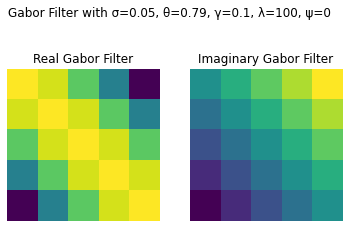

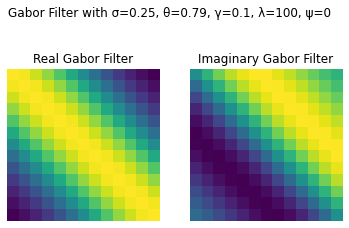

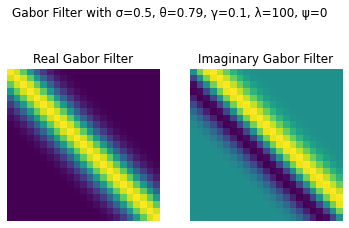

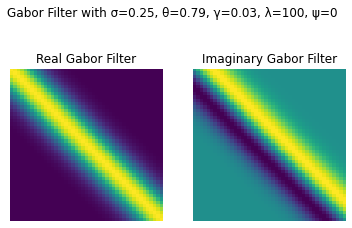

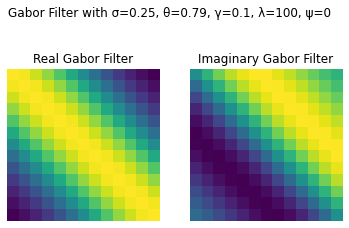

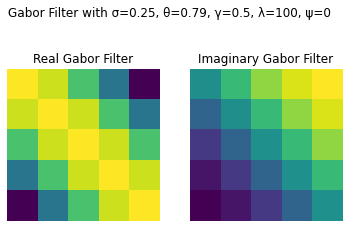

In [14]:
# Constant parameters
lamda = 100
psi = 0

# Experiment Parameters
theta = [0,np.pi/4, np.pi/2]
sigma = [0.05,0.25,0.5]
gamma = [0.025, 0.1, 0.5]  # get numbers from exponential space

# Test theta
for t in theta:
    s = 0.5
    g = 0.1
    gabor = createGabor(s, t, lamda, psi, g)       

# Test sigma
for s in sigma:
    t = np.pi/4
    g = 0.1
    gabor = createGabor(s, t, lamda, psi, g, visualize=True)     
            
# Test gamma
for g in gamma:
    s = 0.25
    t = np.pi/4
    gabor = createGabor(s, t, lamda, psi, g, visualize=True)

As can be seen from the results:
- Theta affects the angle of the pattern in the filter. With a value of 0 we get a vertical pattern, whereas with a value of π/2 we get a horizontal pattern.

- Sigma affects the resolution of the pattern. With a lower value it has a lower resolution, whereas with a higher value it has a higher one.

- Gamma affects the pattern in a similar way to how sigma does but inversed. With a lower value it has a higher resolution, whereas with a higher value it has a lower one.



# 4 Applications in image processing 

## 4.1 Noise in digital images

The quality of digital images can be affected in different ways. For example, the
acquisition process can be very noisy and with a low-resolution (e.g. some medical
imaging modalities only generate a 128x128 image). Noise can also come from the
user who set wrong parameters on the digital camera. Consequently, different computer vision algorithms are required to enhance noisy or corrupted images. With the
growing amount of photos taken every day, image enhancement has then become a
very active area of research.

In this section, we only focus on simple algorithms to correct noise coming typically from the sensor of your camera. Many other types of noise or corruption can happen but are out of the scope of this assignment.

### 4.1.1 Salt-and-pepper noise

Noise can also occur with over-exposition causing a ”hot” pixel or with a defective
sensor causing a ”dead” pixel. This is called salt-and-pepper noise. Pixels in the
image are randomly replaced by either a white or black pixel.

### 4.1.2 Additive Gaussian noise

Noise also occurs frequently when the camera heats up. This is called thermal noise
and this can be modeled as an additive Gaussian noise. Every pixel in the image
has a noise component that corresponds to a random value chosen independently
from the same Gaussian probability distribution. The Gaussian distribution has a
mean of 0 and its standard deviation corresponds to a parameter.

\begin{equation}
\begin{array}{rl}
\mathbf{I}^{\prime}(x) = \mathbf{I}(x) + \epsilon \text{, where } \epsilon \sim  \mathcal{N}(0, \sigma^2)
\end{array}
\end{equation}

where $\mathbf{I}^{\prime}$ is the noisy image and $\mathbf{I}$ is the original image without any noise $\epsilon$.

## 4.2 Image denoising

### 4.2.1 Quantitative evaluation

The peak signal-to-noise ratio (PSNR) is a commonly used metric to quantitatively evaluate the performance of image enhancement algorithms. It is derived from the mean squared error (MSE):

\begin{equation}
\begin{array}{rl}
MSE = \frac{1}{m \cdot n}\sum\limits_{x,y}\Big[\mathbf{I}(x,y) - \mathbf{\hat{I}}(x,y)\Big]^2
\end{array}
\end{equation}
where $\mathbf{I}$ is the original image of size $m\times n$ and $\mathbf{\hat{I}}$ its approximation (i.e. in our case an enhanced corrupted image). The PSNR corresponds to:

\begin{equation}
\begin{split}
PSNR & = 10 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}^2}{MSE}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{\sqrt{MSE}}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{RMSE}\Big)
\end{split}
\end{equation}
where $\mathbf{I}_{max}$ is the maximum pixel value of $\mathbf{I}$ and RMSE is the root of the MSE.



### Exercise

Implement **myPSNR**

**Note:** You are not allowed to use the Python built-in functions provided in *PIL* and *Skimage*.

In [15]:
def myPSNR(orig_image, approx_image):
    
    RMSE = np.sqrt(np.mean((orig_image.flatten() - approx_image.flatten())**2))
    Imax = np.max(orig_image.flatten())
    PSNR = 20 *np.log10(Imax / RMSE)
    return PSNR

image1_orig = (cv2.imread('./sample_data/image1.jpg') /255).astype('float32')
image1_gaussian = (cv2.imread('./sample_data/image1_gaussian.jpg')/255).astype('float32')
image1_saltpepper = (cv2.imread('./sample_data/image1_saltpepper.jpg')/255).astype('float32')

print(myPSNR(image1_orig, image1_saltpepper))
print(myPSNR(image1_orig, image1_gaussian))

15.463817119598389
17.102439403533936


### Questions (10 pts)
1.   Explain briefly in your own words what the PSNR is (without any equations). When comparing different methods with the PSNR metric, is a higher value the better or the opposite?


The PSNR is the ratio between the highest possible intensity value of an image and the error that occurs by altering it in some way (usually compression). The lower the value, the better because that would mean a lower error. 

2.   Using your implemented function **myPSNR**, compute the PSNR between image1_saltpepper.jpg and image1.jpg. What PSNR value did you get?

  **Hint:**
Make sure that dtype of image is float32.

The PSNR value was 15.463817119598389.

3.   Using your implemented function **myPSNR**, compute the PSNR between image1_gaussian.jpg and image1.jpg. What PSNR value did you get?

The PSNR value was 17.102439403533936.

### 4.2.2 Neighborhood processing for image denoising

We will now design filters to remove these two types of noise. The function will denoise the image by either applying:

1. *box filtering*: You can use **cv2.blur** function.
2. *median filtering*: You can use **cv2.medianBlur** function.
3. *Gaussian filtering*: You must use your **cv2.GaussianBlur** function.

### Exercise

Implement **denoise**

**Hints:** 
1. **kernel_type** is just a string to specify the kernel type.
2. ****kwargs** allows to have an undefined key-value pairs in a Python function. For example, you can have **sigma** and  **kernel_size** as argument when using a Gaussian kernel but only **kernel_size** when using a box kernel. For more information about how ****kwargs** works, take a look at [usage of kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

In [16]:
def denoise(image, kernel_type, **kwargs):
    ksize = kwargs['ksize']
    if kernel_type == 'box':
        imOut = cv2.blur(image, (ksize, ksize))
    elif kernel_type == 'median':
        imOut = cv2.medianBlur(image, ksize)
    elif kernel_type == 'gaussian':
        sigma = kwargs['sigma']
        imOut = cv2.GaussianBlur(image, (ksize, ksize), sigma)
    else:
        print('Operation Not implemented')
    return imOut

### Question (20 pts)
1.   Using your implemented function **denoise**, try denoising image1_saltpepper.jpg and image1_gaussian.jpg by applying the following filters:

      (a) Box filtering of size: 3x3, 5x5, and 7x7.

      (b) Median filtering with size: 3x3, 5x5 and 7x7.

     Show the denoised images in the cell below. You can use tables to present your quantitative results.



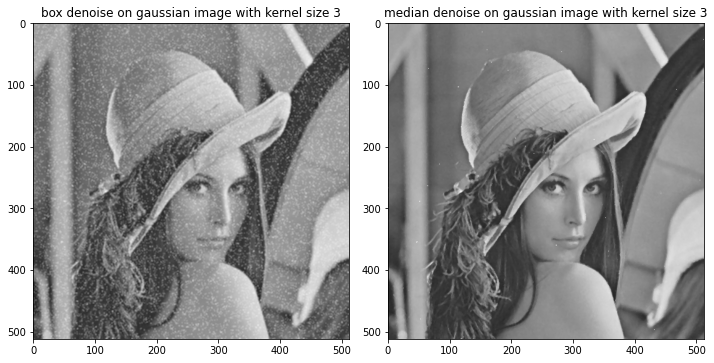

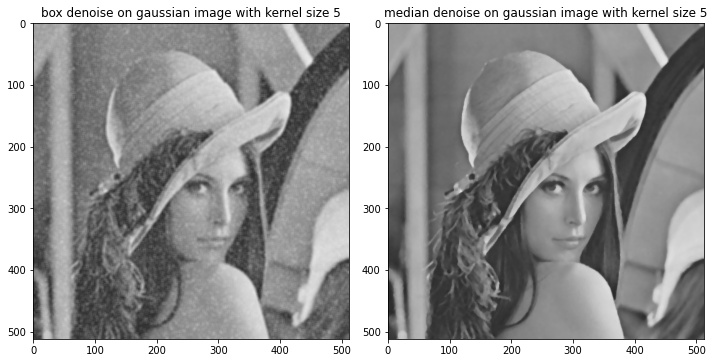

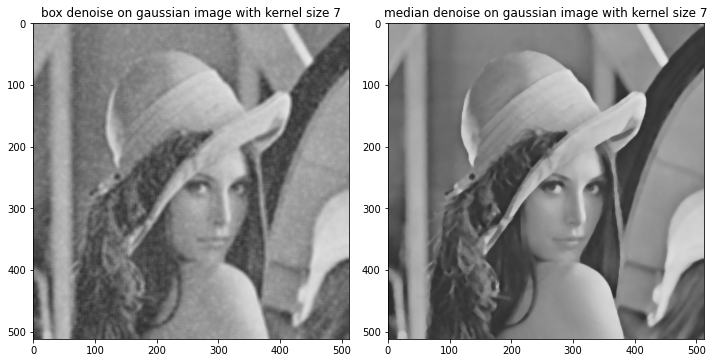

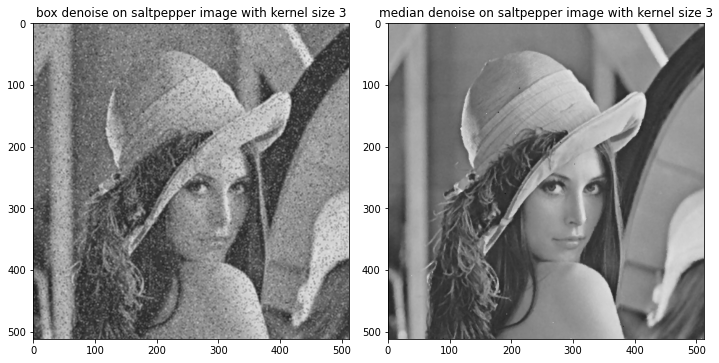

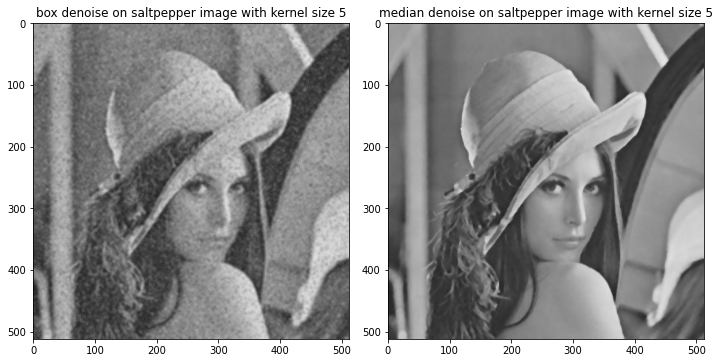

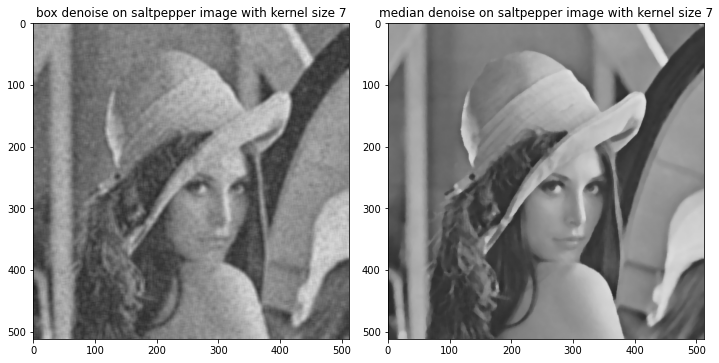

In [17]:
denoised_images = {}

for image in ['./sample_data/image1_gaussian.jpg', './sample_data/image1_saltpepper.jpg']:
    for size in [3,5,7]:
        fig = plt.figure(figsize=(10, 15))
        im_nr = 0
        for filt in ['box', 'median']:
            im_nr += 1
            img = cv2.imread(image)
            denoised_image = denoise(img, filt, ksize = size)
            denoised_images[image[21:-4] + '_' + filt + '_' + str(size)] = denoised_image
            ax = plt.subplot(1, 2, im_nr)
            ax.imshow(denoised_image)
            ax.set_title('{} denoise on {} image with kernel size {}'.format(filt, image[21:-4], size))
            fig.tight_layout()
            fig.subplots_adjust(top=1.6)

2.   Using your implemented function **myPSNR**, compute the PSNR for every denoised image (12 in total) wrt the original image. What is the effect of the filter size on the PSNR? Report the results (in a table) and discuss.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky" colspan="3">SaltPepper</th>
    <th class="tg-0pky" colspan="3">Gaussian</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky" colspan="2">box</td>
    <td class="tg-0pky">median</td>
    <td class="tg-0pky" colspan="2">box</td>
    <td class="tg-0pky">median</td>
  </tr>
  <tr>
    <td class="tg-0pky">k = 3</td>
    <td class="tg-0pky" colspan="2">24.168684482574463</td>
    <td class="tg-0pky">34.6651291847229</td>
    <td class="tg-0pky" colspan="2">24.25205945968628</td>
    <td class="tg-0pky">34.49052095413208</td>
  </tr>
  <tr>
    <td class="tg-0pky">k = 5</td>
    <td class="tg-0pky" colspan="2">26.093528270721436</td>
    <td class="tg-0pky">31.71703815460205</td>
    <td class="tg-0pky" colspan="2">25.106263160705566</td>
    <td class="tg-0pky">31.788606643676758</td>
  </tr>
  <tr>
    <td class="tg-0pky">k = 7</td>
    <td class="tg-0pky" colspan="2">25.968987941741943</td>
    <td class="tg-0pky">29.717094898223877</td>
    <td class="tg-0pky" colspan="2">24.75747585296631</td>
    <td class="tg-0pky">29.73698139190674</td>
  </tr>
</tbody>
</table>

The filter size increases the error of the denoised image. This is probably the case because the image blurs more when a larger kernel is selected.

3.   Which is better for the salt-and-pepper noise, box or median filters? Why? What about the Gaussian noise?


The median filter is better for both salt-and-pepper and gaussian noise. This is the case because the median takes an actual value in its neighborhood which results in more representative pixel values than when taking an average, which can be influenced by outliers.


4.   Try denoising image1_gaussian.jpg using a Gaussian filtering. Choose an appropriate window size and standard deviation and justify your choice. Show the denoised images in the cell below.


5.157514810562134


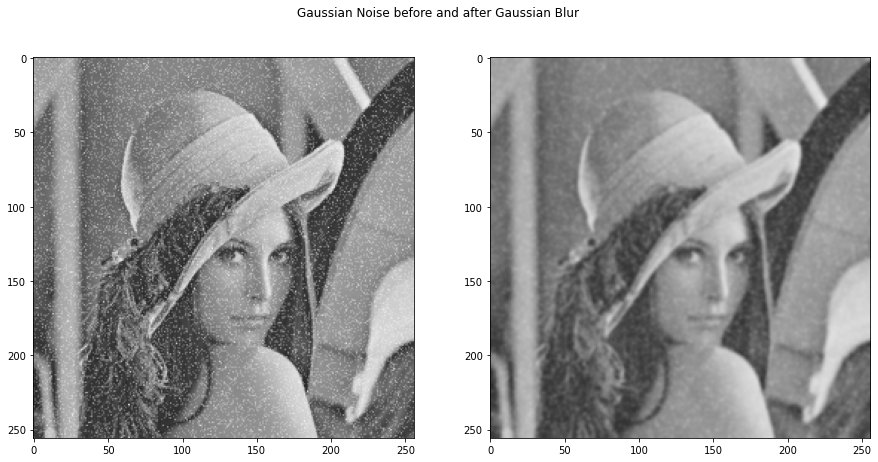

In [18]:
image1_orig = cv2.imread('./sample_data/image1.jpg')
image1_gaussian = cv2.imread('./sample_data/image1_gaussian.jpg')

image1_gaussian = cv2.resize(image1_gaussian, (0, 0), fx=0.5, fy=0.5)
image1_orig = cv2.resize(image1_orig, (0, 0), fx=0.5, fy=0.5)

denoised_gaussian = denoise(image1_gaussian, 'gaussian', ksize = 7, sigma = 1)

print(myPSNR(image1_orig, (denoised_gaussian/255).astype('float32')))
fig = plt.figure(figsize=(15, 20))
plt.subplot(1, 2, 1)
plt.imshow(image1_gaussian)
plt.subplot(1, 2, 2)
plt.imshow(denoised_gaussian)
fig.suptitle('Gaussian Noise before and after Gaussian Blur')
fig.subplots_adjust(top=1.5)
plt.show()


5.   What is the effect of the standard deviation on the PSNR? Report the results (in a table) and discuss.


In [19]:
image1_orig = cv2.imread('./sample_data/image1.jpg')
image1_gaussian = cv2.imread('./sample_data/image1_gaussian.jpg')

print('std | PSNR')
print('_______________________')
for std in np.linspace(0, 5.0, num=20):
    ret = denoise(image1_gaussian, 'gaussian', ksize = 5, sigma = std)
    PSNR = myPSNR(image1_orig, (ret/255).astype('float32'))
    print('{} | {}'.format(str(std)[:3], PSNR))
print('')
print('It makes no difference? I know that a larger sigma is supposed to result in more blurring because the gaussian is flatter and pixels in the neighborhood would have more corresponding weights. But it seems the image barely changes after a different sigma is used... ¯\_(ツ)_/¯')

std | PSNR
_______________________
0.0 | 5.61583936214447
0.2 | 5.615943670272827
0.5 | 5.615915060043335
0.7 | 5.6155925989151
1.0 | 5.61583936214447
1.3 | 5.6158143281936646
1.5 | 5.615242123603821
1.8 | 5.6160736083984375
2.1 | 5.61550498008728
2.3 | 5.615500807762146
2.6 | 5.616057515144348
2.8 | 5.615494251251221
3.1 | 5.6157732009887695
3.4 | 5.615772008895874
3.6 | 5.615490674972534
3.9 | 5.616051554679871
4.2 | 5.615769624710083
4.4 | 5.6157684326171875
4.7 | 5.615487098693848
5.0 | 5.615487098693848

It makes no difference? I know that a larger sigma is supposed to result in more blurring because the gaussian is flatter and pixels in the neighborhood would have more corresponding weights. But it seems the image barely changes after a different sigma is used... ¯\_(ツ)_/¯



6.   What is the difference among median filtering, box filtering and Gaussian filtering? Briefly explain how they are different at a conceptual level. If two filtering methods give a PSNR in the same ballpark, can you see a qualitative difference?

Box filtering simply takes an average of neighborhood, median filtering takes the median of the neighborhood, and gaussian takes a weighted average of the neighborhood values, where the weights in the kernel follow a gaussian shape. The box filter and gaussian filter give similar results as they perform similar operations, although the gaussian filter does give smoother results. The median filter preservers edges better as discussed before.

## 4.3 Edge detection

Edges appear when there is a sharp change in brightness. In an image this usually corresponds to the boundaries of an object. Edge detection is a fundamental task used in many computer vision applications. One of them is road detection in autonomous driving, which is used for determining the vehicle trajectory.

Many different techniques exist for computing the edges. In this section, we will focus on filters that extract the gradient of the image. We will try to detect the road in an still image.

### 4.3.1 First-order derivative filters


**Sobel** kernels approximate the first derivative of a Gaussian filter. Below are the Sobel kernels used in the $x$ and $y$ directions.

\begin{equation}
\begin{array}{rl}
G_x = \begin{bmatrix} +1 & 0 & -1 \\ +2 & 0 & -2 \\ +1 & 0 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}

\begin{equation}
\begin{array}{rl}
G_y = \begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}
The gradient magnitude is defined as the square root of the sum of the squares of the horizontal ($G_x$) and the vertical ($G_y$) components of the gradient of an image, such that: 
\begin{equation}
G =\sqrt {{G_x}^2+{G_y}^2}
\end{equation}
The gradient direction is calculated as follows:
\begin{equation}
\theta= \tan ^{ - 1}{\frac{G_y}{G_x}}
\end{equation}


### Question (10 pts)
Using your implemented function **compute_gradient** on image2.jpg, display the following figures:

  1. The gradient of the image in the x-direction.

  2. The gradient of the image in the y-direction.

  3. The gradient magnitude of each pixel.

  4. The gradient direction of each pixel.

Discuss what kind of information every image conveys.



1. The upper left image displays the x-component of the gradient of the image (smoothened by a Gaussian blur) (i.e., roughly how much the pixel value is changing between neighbouring pixels in the horizontal direction).
2. The upper right image displays the y-component of the gradient of the image (smoothened by a Gaussian blur) (i.e., roughly how much the pixel value is changing between neighbouring pixels in the vertical direction).
3. The lower left image displays the magnitude of the gradient vector $(G_x, G_y)^T$ (i.e., roughly the change of pixelvalue in the direction where it is largest).
4. The lower right image displays the direction (as an angle  $\theta \in [-\pi/2, \pi/2]$) of the gradient vector (i.e., the direction in which the change of pixel value is largest).

### Exercise

Implement **compute_gradient**

**Note:** 
You are not allowed to use the Python built-in functions for computing gradient. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [ ]:
def compute_gradient(image):
    
    Sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
    Sobel_y = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
    
    Gx = conv(image, Sobel_x)
    Gy = conv(image, Sobel_y)
    
    im_magnitude = np.sqrt(Gx**2 + Gy**2 )
    im_direction = np.arctan(np.divide(Gy, Gx))

    return Gx, Gy, im_magnitude,im_direction

In [ ]:
path = './sample_data/'
resize_factor = 0.4
img = cv2.imread(path+'image2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
print(img.shape)
Gx, Gy, im_mag, im_dir = compute_gradient(img)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
ax1.imshow(Gx, cmap='gray')
ax1.set_title(r'$G_x$')
ax2.imshow(Gy, cmap='gray')
ax2.set_title(r'$G_y$')
ax3.imshow(im_mag, cmap='gray')
ax3.set_title(r'$G$')
ax4.imshow(im_dir, cmap='gray')
ax4.set_title(r'$\theta$')
plt.tight_layout()

### 4.3.2 Second-order derivative filters

Compared to the Sobel filter, a Laplacian of Gaussian (LoG) relies on the second derivative of a Gaussian filter. Hence, it will focus on large gradients in the image. A LoG can be computed by the following three methods:



*   method 1: Smoothing the image with a Gaussian kernel (kernel size of 5 and standard deviation of 0.5), then taking the Laplacian of the smoothed image (i.e. second derivative).
*   method 2: Convolving the image directly with a LoG kernel (kernel size of 5 and standard deviation of 0.5).

*   method 3: Taking the Difference of two Gaussians (DoG) computed at different scales $\sigma_1$ and $\sigma_2$.





### Exercise 

Implement **compute_LoG**

The function should be able to apply any of the above mentioned methods depending on the value passed to the parameter *LOG_type*

**Note:** 
You are not allowed to use the Python built-in functions for computing LOG kernels. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [ ]:
def Laplacian():
    L = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    return L


def LoG_kernel(sigma_x, sigma_y, kernel_size):
    G = gauss2D(sigma_x, sigma_y, kernel_size)
    LoG = conv(Laplacian(), G)
    
    return LoG

def DoG_kernel(sigma_x1, sigma_y1, sigma_x2, sigma_y2, kernel_size):
    
    if sigma_x1 <= sigma_x2 or sigma_y1 <= sigma_y2:
        raise ValueError('The standard deviation of the first kernel ' 
                         'should be larger the standard deviation of the second kernel.')
    
    G1 = gauss2D(sigma_x1, sigma_y1, kernel_size)
    G2 = gauss2D(sigma_x2, sigma_y2, kernel_size)
    
    DoG = G1 - G2
    DoG = DoG
    
    return DoG

def compute_LoG(image, LOG_type):

    if LOG_type == 1:
        #method 1
        L = Laplacian()
        img = conv(image, gauss2D(0.5, 0.5, 5))
        imOut = conv(img, L)

    elif LOG_type == 2:
        #method 2
        LoG = LoG_kernel(0.5, 0.5, 5)
        imOut = conv(image, LoG)

    elif LOG_type == 3:
        #method 3
        DoG = DoG_kernel(0.5*np.sqrt(2.), 0.5*np.sqrt(2.), 0.5/np.sqrt(2), 0.5/np.sqrt(2), 5)
        imOut = conv(image, DoG)

    return imOut

def edge_detection(image, threshold=0.01):
    """
    simple algorithm to detect zero-crossings (edges)
    """
    h, w = image.shape
    edges = np.zeros((h, w))
    for i in range(1, h -1):
        for j in range(1, w -1):
            nbh = image[i-1: i+1, j-1: j+1]
            if np.max(nbh) > threshold and np.min(nbh) < -threshold:
                edges[i+1, j+1] = 1.
    
    return edges
            
    
            

### Questions (10 pts)

1.   Test your function using image2.jpg and visualize your results using the three methods.





In [ ]:
eps = 0.0007

img1 = compute_LoG(img, 1)
img1_norm = img1/np.linalg.norm(img1)
img2 = compute_LoG(img, 2)
img2_norm = img2/np.linalg.norm(img2)
img3 = compute_LoG(img, 3)
img3_norm = img3/np.linalg.norm(img3)

img1_edge = edge_detection(img1_norm, threshold=eps)
img2_edge = edge_detection(img2_norm, threshold=eps)
img3_edge = edge_detection(img3_norm, threshold=eps)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))

fig1 = ax1.imshow(img1_norm, cmap='gray')
ax1.set_title('1: Laplacian + Gaussian')
fig2 = ax2.imshow(img2_norm, cmap='gray')
ax2.set_title('2: LoG')
fig3 = ax3.imshow(img3_norm, cmap='gray')
ax3.set_title('3: DoG')

fig4 = ax4.imshow(img1_edge, cmap='gray')
ax4.set_title('1: Laplacian + Gaussian (edges)')
fig5 = ax5.imshow(img2_edge, cmap='gray')
ax5.set_title('2: LoG (edges)')
fig6 = ax6.imshow(img3_edge, cmap='gray')
ax6.set_title('3: DoG (edges)')
plt.tight_layout()
plt.show()




2.   Discuss the difference between applying the three methods.


Mathematically speaking, the first and second method should give the exact same result, since, by the distributivity of the convolution operator $\nabla^2 * (G * I) = (\nabla^2 * G) * I$; i.e., first smoothening the image with a gaussian filter and then applying the Laplacian on the smoothened image is mathematically speaking equal to first computing the Laplacian of the Gaussian (LoG) and applying this filter on the image. Any difference in the results should be attributed to computational rounding errors. The third method differs slightly from the first two since the difference of two gaussians (DoG) with different standard deviations only approximates the LoG. Nonetheless from the figures above it is clear that the resulting images appear the same. Due to the low contrast this is hard to see from the convoluted pictures (top row), so we used a simple, yet rough edge detection algorithm to make the results more clear (bottom row). From these figures we can clearly identify the lines on the road as well as the boundaries between the forrest and the ground and the forrest and the sky.

3.   In the first method, why is it important to convolve an image with a Gaussian before convolving with a Laplacian?



The Laplacian is measuring large differences in pixel value between neighbouring pixels. One place where this occurs is around edges, which is what we are interested in, however, this is also the case wherever there is noise in the image. To reduce this effect of noise on the Laplacian, we first convolve the image with a Gaussian, which smoothenes the image (i.e., filters out the noise) so that we are only presented the actual edges when convolving with the Laplacian.

4.   In the third method, what is the best ratio between $\sigma_1$ and $\sigma_2$ to achieve the best approximation of the LoG? What is the purpose of having 2 standard deviations?



The optimal ratio between the 2 sigmas is ~1.6 [1]. The effect of the 2 different sigmas can be explained as follows. We apply two Gaussian blur filters with slightly different standard deviation to the image seperately, Then subtracting these images from each other, the resulting image contains the largest values precisely there where the image is most susceptible to a slight change in standard deviation of a gaussian blur filter. This is precisely around the edges. 


[1]  D. Marr; E. Hildreth (29 February 1980). "Theory of Edge Detection". Proceedings of the Royal Society of London. Series B, Biological Sciences. 207 (1167): 215–217

5.   What else is needed to improve the performance and isolate the road,  i.e. what else should be done? You don't have to provide any specific parameter or specific algorithm. Try to propose a direction which would be interesting to explore and how you would approach it.


One way to improve the performance has already been applied in the process above, namely selecting the edges by checking for zero-crossings with a certain treshold. This selects only those zero-crossings where the difference between the negative and positive neighbours is large, which typically happens around an edge (and not for instance where there is noise). Clearly, this helps distinguish the road from its surroundings, however, there seem to be a lot of edges in the trees as well. If we are not interested in those edges but only in the road (for instance for self-driving cars) we could isolate a region in the images where the road lines are expected and only consider those (e.g. a triangular region in the bottom half of the image)

## 4.4 Foreground-background separation

Foreground-background separation is an important task in the field of computer vision (see Figure). In this exercise, you will implement a simple unsupervised algorithm that leverages the variations in texture to segment the foreground object from the background. We will assume the foreground object has a distinct combination of textures compared to background. As mentioned earlier, Gabor filters are well-suited for texture analysis thanks to their frequency domain characteristics. Therefore, we will use a collection of Gabor filters with varying scale and orientations which we call a *filter bank*. The outline of the algorithm is as follows:

![](https://drive.google.com/uc?export=view&id=1w60xJ4UlG60Ie6ljRkHn0GJDdVu9eb5e)

**(Left)** Input image, **(Middle)** Foreground mask, **(Right)** Masked object. Foreground-Background separation aims at masking out the salient object pixels from the background pixels.

---

**Algorithm 1** Foreground-Background Segmentation Algorithm

---

**Input:** $x$ - input image

**Output:** $y$ - pixelwise labels



1.   Convert to grayscale if necessary.

>>**if** $x$ is RGB **then**

>>>$x$ $\leftarrow$ rgb2gray($x$)

>>**end if**

2.   Create Gabor filterbank, $\mathcal{F}_{gabor}$, with varying $\sigma$, $\lambda$ and $\theta$.

3.   Filter $x$ with the filterbank. Store each output in $fmaps$.

4.   Compute the magnitude of the complex $fmaps$. Store the results in $fmags$.

>>$fmags$ $\leftarrow$  $\vert fmaps \vert$

5.   Smooth $fmags$.

>>$fmags$ $\leftarrow$  smooth($fmags$)

6.   Convert $fmags$ into data matrix, $f$.

>>$f$ $\leftarrow$  reshape($fmags$)

7.   Cluster $f$ using kmeans into two sets.

>>$y$ $\leftarrow$  kmeans($f$, 2)

---


### Questions (20 pts)

1.   Run the algorithm on all test images with the provided parameter settings. What do you observe? Explain shortly.


We observe that the algorithm did not accurately separate the image from the background using the given parameters. Examples of problematic images are those with objects with extreme variations of black and white (Cows), those with backgrounds that include a range of black and white tones similar to the image (Kobi) and finally those that include objects without well-defined borders (Science Park).


2.   Experiment with different $\lambda$, $\sigma$ and $\theta$ settings until you get reasonable outputs. Report what parameter settings work better for each input image and try to explain why.

>**Hint:** 
Don't change multiple variables at once. You might not need to change some at all.



- Default Parameters:
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: [0,π/4, 2π/4, 3π/4, π]
- Kobi: A smaller selection of theta values improved the result. We believe the selection of less theta values helps because the background consists mainly of vertical, diagonal and horizontal lines.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: **[0,π/2,π]**
- Polar: We could not achieve a better result by changing the parameters.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: [0,π/4, 2π/4, 3π/4, π]
- Robin-1: Choosing a smaller sigma improved the results. We believe this is because the object and the background are already defined well and therefore, adding more smoothing to the image obscures the definition of the edges and worsens the result as the color of the background and the object gets mixed up at some places.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: **[0.01]**
    - θ: [0,π/4, 2π/4, 3π/4, π]
- Robin-2: We could not achieve a better result by changing the parameters.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: [0,π/4, 2π/4, 3π/4, π]
- Cows: A smaller selection of theta values improved the result. We believe the selection of less theta values helps because the background consists mainly of vertical and horizontal lines.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: **[0, π]**
- SciencePark: We could not achieve a better result by changing the parameters. We would expect that using a theta of [0.π] would give better results since the image consists of mainly horizontal and vertical lines. However, that is not the case most likely because the image doesn't contain any well-defined objects so it cannot segment them properly in any case.
    - λ: [4/sqrt(2), ... , sqrt(|numRows|^2 + |numCols|^2)]
    - σ: [1,2]
    - θ: [0,π/4, 2π/4, 3π/4, π]

3.   After you achieve good separation on all test images, run the script again with corresponding parameters but this time with

>>>smoothingFlag = False

>Describe what you observe at the output when smoothing is not applied on the magnitude images. Explain why it happens and try to reason about the motivation behind this step.

In all cases the result of the segmentation appears to be worse. The reason it happens is that sometimes the object has a lot of texture and complexity which hinders the algorithm from doing segmentation properly. We need smoothing to remove that extra information so that the algorithm can better identify the external edges of the object, while ignoring the "internal" edges, that is, the lines caused by the features (e.g. nose, eyes) and texture (e.g. fur, feathers, pattern) of the object.

### Exercise

Please get yourself familiar with provided skeleton code **gabor_segmentation**.py. Keep in mind that you will need your implementation of the **createGabor** function.

When you succesfully implement it all, it should run without problems and produce a reasonable segmentation with the default parameters on **kobi.png**.

In [ ]:
image_id = "Kobi"
img = load_image(image_id)

show_image(img, f'Input image: {image_id}')


In [ ]:
# Control settings
visFlag       = False    #  Set to true to visualize filter responses.
smoothingFlag = True   #  Set to true to postprocess filter outputs.

# Design array of Gabor Filters
# In this code section, you will create a Gabor Filterbank. A filterbank is
# a collection of filters with varying properties (e.g. {shape, texture}).
# A Gabor filterbank consists of Gabor filters of distinct orientations
# and scales. We will use this bank to extract texture information from the
# input image. 

numRows, numCols = img.shape

# Estimate the minimum and maximum of the wavelengths for the sinusoidal
# carriers. 
# ** This step is pretty much standard, therefore, you don't have to
#    worry about it. It is cycles in pixels. **   
lambdaMin = 4/np.sqrt(2)
lambdaMax = np.sqrt(abs(numRows)**2 + abs(numCols)**2)

# Specify the carrier wavelengths.  
# (or the central frequency of the carrier signal, which is 1/lambda)
n = np.floor(np.log2(lambdaMax/lambdaMin))
lambdas = 2**np.arange(0, (n-2)+1) * lambdaMin

# Define the set of orientations for the Gaussian envelope.
dTheta       = 2 * np.pi / 8               # \\ the step size
orientations = np.arange(0, np.pi+dTheta, dTheta)        

# Define the set of sigmas for the Gaussian envelope. Sigma here defines 
# the standard deviation, or the spread of the Gaussian. 
sigmas = np.array([1,2])

# Now you can create the filterbank. We provide you with a Python list
# called gaborFilterBank in which we will hold the filters and their
# corresponding parameters such as sigma, lambda and etc. 
# ** All you need to do is to implement createGabor(). Rest will be handled
#    by the provided code block. **
gaborFilterBank = []
tic = time.time()
for lmbda in lambdas:
    for sigma in sigmas:
        for theta in orientations:
            # Filter parameter configuration for this filter.
            psi    = 0
            gamma  = 0.5
            
            filter_config = {}
            filter_config["filterPairs"] = createGabor( sigma, theta, lmbda, psi, gamma )
            filter_config["sigma"]       = sigma
            filter_config["lmbda"]       = lmbda
            filter_config["theta"]       = theta
            filter_config["psi"]         = psi
            filter_config["gamma"]       = gamma
            gaborFilterBank.append(filter_config)
ctime = time.time() - tic

print('--------------------------------------\n \t\tDetails\n--------------------------------------')
print(f'Total number of filters       : {len(gaborFilterBank)}')
print(f'Number of scales (sigma)      : {len(sigmas)}')
print(f'Number of orientations (theta): {len(orientations)}')
print(f'Number of carriers (lambda)   : {len(lambdas)}')
print(f'---------------------------------------')
print(f'Filter bank created in {ctime} seconds.')
print(f'---------------------------------------')

# Filter images using Gabor filter bank using quadrature pairs (real and imaginary parts)
# You will now filter the input image with each complex Gabor filter in 
# gaborFilterBank structure and store the output in the cell called 
# featureMaps. 
# // Hint-1: Apply both the real imaginary parts of each kernel 
#            separately in the spatial domain (i.e. over the image). //
# // Hint-2: Assign each output (i.e. real and imaginary parts) in
#            variables called real_out and imag_out. //
# // Hint-3: Use built-in cv2 function, filter2D, to convolve the filter
#            with the input image. Check the options for padding. Find 
#            the one that works well. You might want to
#            explain what works better and why shortly in the report.
featureMaps = []

for gf_i, gaborFilter in enumerate(gaborFilterBank):
    
    # print(f'Processing filter #{gf_i}')
    
    # gaborFilter["filterPairs"] has two elements. One is related to the real part 
    # of the Gabor Filter and the other one is the imagineray part.
    real_out = conv(img, gaborFilter['filterPairs'][:,:,0], mode='same').astype('float32')
    imag_out = conv(img, gaborFilter['filterPairs'][:,:,1], mode='same').astype('float32')
    featureMaps.append(np.stack((real_out, imag_out), 2))
    
    # Visualize the filter responses if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(real_out)    # Real
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(imag_out)    # Imaginary
        title = "Im[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")
        plt.show()

        
# Compute the magnitude
# Now, you will compute the magnitude of the output responses.
# \\ Hint: (real_part^2 + imaginary_part^2)^(1/2) \\
featureMags = []
for i, fm in enumerate(featureMaps):
    real_part = fm[...,0]
    imag_part = fm[...,1]
    mag = np.sqrt(real_part**2 + imag_part**2)
    featureMags.append(mag)
    
    # Visualize the magnitude response if you wish.
    if visFlag:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mag.astype(np.uint8))    # visualize magnitude
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilterBank[i]["lmbda"], 
                                                                                                 gaborFilterBank[i]["theta"], 
                                                                                                 gaborFilterBank[i]["sigma"])
        ax.set_title(title)
        ax.axis("off")
        
# Prepare and Preprocess features 
# You can think of each filter response as a sort of feature representation
# for the pixels. Now that you have numFilters = |gaborFilterBank| filters, 
# we can represent each pixel by this many features. 
# \\ Q: What kind of features do you think gabor filters might correspond to? 

# You will now implement a smoothing operation over the magnitude images in
# featureMags. 
# \\ Hint: For each i in [1, length(featureMags)], smooth featureMags{i}
#          using an appropriate first order Gaussian kernel.
# \\ Hint: cv2 filter2D function is helpful here.   
features = np.zeros(shape=(numRows, numCols, len(featureMags)))
if smoothingFlag:
    pass
    for i, fmag in enumerate(featureMags):
        fmag = cv2.filter2D(fmag, -1, gauss2D(4, 4, 3)) 
        features[:,:,i] = fmag
else:
    # Don't smooth but just insert magnitude images into the matrix
    # called features.
    for i, fmag in enumerate(featureMags):
        features[:,:,i] = fmag

# Reshape the filter outputs (i.e. tensor called features) of size 
# [numRows, numCols, numFilters] into a matrix of size [numRows*numCols, numFilters]
# This will constitute our data matrix which represents each pixel in the 
# input image with numFilters features.  

features = np.reshape(features, newshape=(numRows * numCols, -1))

# Standardize features. 
# \\ Hint: see http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing for more information.

features = scale(features)

# (Optional) Visualize the saliency map using the first principal component 
# of the features matrix. It will be useful to diagnose possible problems 
# with the pipeline and filterbank.

transformed_feature = PCA(n_components=1).fit_transform(features) # select the first component
transformed_feature = np.ascontiguousarray(transformed_feature, dtype=np.float32)
feature2DImage = np.reshape(transformed_feature,newshape=(numRows,numCols))
plt.figure()
plt.title(f'Pixel representation projected onto first PC')
plt.imshow(feature2DImage, cmap='gray')
plt.axis("off") 
plt.show()

# Apply k-means algorithm to cluster pixels using the data matrix,
# features. 
# \\ Hint-1: search about sklearn kmeans function https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.
# \\ Hint-2: use the parameter k defined in the first section when calling
#            sklearn's built-in kmeans function.
tic = time.time()
pixLabels = KMeans(n_clusters=2).fit(features).labels_
ctime = time.time() - tic
print(f'Clustering completed in {ctime} seconds.')



# Visualize the clustering by reshaping pixLabels into original grayscale
# input size [numRows numCols].
pixLabels = np.reshape(pixLabels, newshape=(numRows, numCols))
plt.figure()
plt.title(f'Pixel clusters')
plt.imshow(pixLabels)
plt.axis("off") 
plt.show()


# Use the pixLabels to visualize segmentation.
Aseg1 = np.zeros_like(img)
Aseg2 = np.zeros_like(img)
BW = pixLabels == 2  # check for the value of your labels in pixLabels (could be 1 or 0 instead of 2)
# BW = np.repeat(BW[:, :, np.newaxis], 3, axis=2) # do this only if you have 3 channels in the img
Aseg1[BW] = img[BW]
Aseg2[~BW] = img[~BW]

plt.figure()
plt.title(f'montage')
plt.imshow(Aseg1, 'gray', interpolation='none')
plt.imshow(Aseg2, 'jet',  interpolation='none', alpha=0.7)
plt.axis("off")
plt.show()